# VISION PIPELINE

## Download/Load Data

In [1]:
import fastai
print(f"FastAi: {fastai.__version__}")

# Import all modules and functions from Fastai's vision package
from fastai.vision.all import * 

# Import get_image_files function for retrieving image file paths
from fastai.data.transforms import get_image_files

# Download and untar the PETS dataset for data preparation
path = untar_data(URLs.PETS)

# Get a list of image file names in the 'images' directory
fnames = get_image_files(path=path/'images')

# Print the total number of images and display the first 10 file names
print(f"Total {len(fnames)} images, {fnames[:10]} ...")

FastAi: 2.7.12


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Total 7390 images, [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_79.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_265.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_182.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_89.jpg')] ...


## Data Preparation

In [2]:
# Load statistics typically used for image data normalization
from fastai.vision.core import imagenet_stats
# Import image augmentation and cropping transformations
from fastai.vision.augment import aug_transforms, RandomResizedCrop

# Define item transforms for image resizing and cropping
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1., 1.))

# Define batch transforms with data augmentation and normalization
batch_tfms = [
    *aug_transforms(size=224, max_warp=0),  # Augmentations
    Normalize.from_stats(*imagenet_stats)   # Data normalization
]

## DataLoader

37 ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


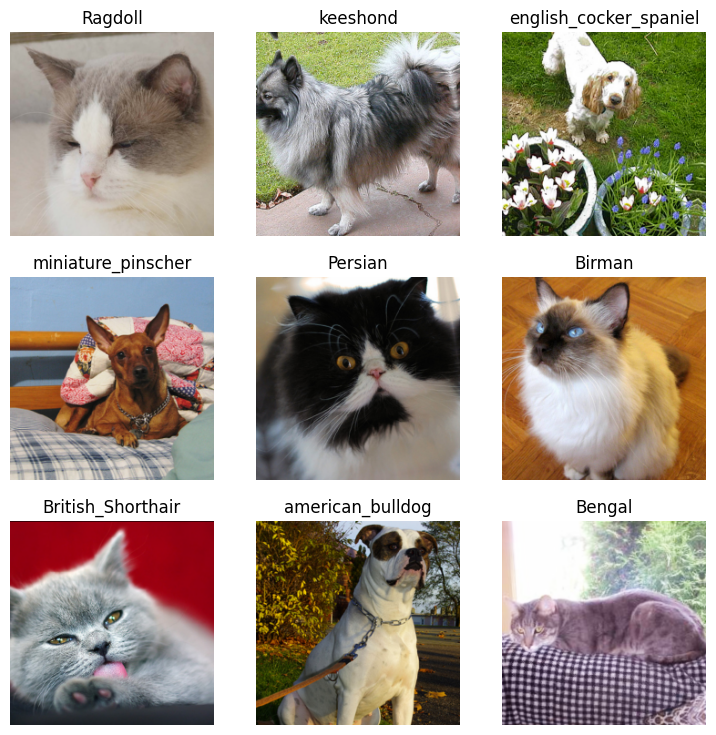

In [3]:
# Use Fastai's DataBlock to specify data processing steps
from fastai.vision.data import ImageBlock
from fastai.data.block import CategoryBlock, DataBlock

# Get image files, split dataset, and label categories using a regular expression
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, RegexLabeller

# Define a DataBlock 'pets' for image classification
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Image and category blocks
    get_items=get_image_files,           # Get image files from a directory
    splitter=RandomSplitter(),           # Randomly split data into train and valid sets
    get_y=RegexLabeller(pat=r'/([^/]+)_\d+.*'),  # Extract category labels from file names
    item_tfms=item_tfms,                 # Item-level transformations
    batch_tfms=batch_tfms                # Batch-level transformations
)

# Create data loaders (dls) using the 'pets' DataBlock
dls = pets.dataloaders(source=path/'images', bs=64)

# Visualize a batch of preprocessed images
dls.show_batch()

# Print the number of classes in the vocabulary
print(f"{len(dls.vocab)} {dls.vocab}")

## Define Model & Find Learning Rate

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


SuggestedLRs(valley=0.0006918309954926372)

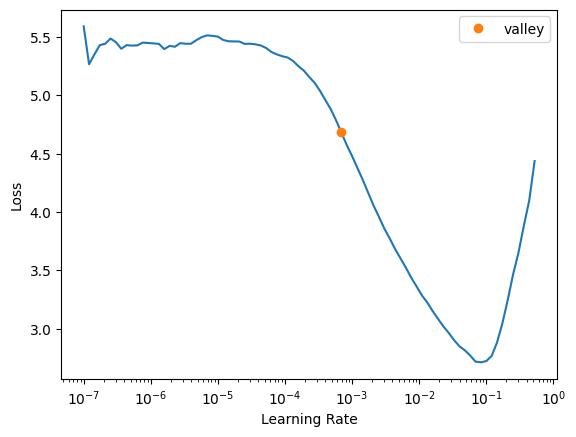

In [4]:
# Enable mixed-precision training
from fastai.callback.fp16 import to_fp16

# Create a vision learner with a ResNet-50 architecture
from fastai.vision.all import vision_learner
from torchvision.models.resnet import resnet50

# Import accuracy and error_rate metrics
from fastai.metrics import accuracy, error_rate

# Create a learner for image classification
learn = vision_learner(
    dls=dls,                  # Data loaders for training and validation
    arch=resnet50,            # Architecture (ResNet-50)
    pretrained=True,          # Use a pre-trained model
    metrics=[accuracy, error_rate]  # List of metrics including accuracy
).to_fp16()                  # Enable mixed-precision training

# Find the optimal learning rate for training
learn.lr_find()

## Model Training

In [5]:
# Learning rate slice from 1e-4 to 1e-2
lr = slice(1e-4, 1e-2)

# Train the model for 4 epochs with a learning rate within the defined range
learn.fit_one_cycle(4, lr_max=lr)

# Save Model
# Save the trained model with the name 'model1_freezed'
learn.save('model1_freezed')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.710537,0.719719,0.864682,0.135318,01:00
1,0.507938,0.372682,0.899188,0.100812,01:00
2,0.296022,0.268197,0.930988,0.069012,01:00
3,0.166540,0.232688,0.932341,0.067659,01:00


Path('models/model1_freezed.pth')

## Model Interpretation

True


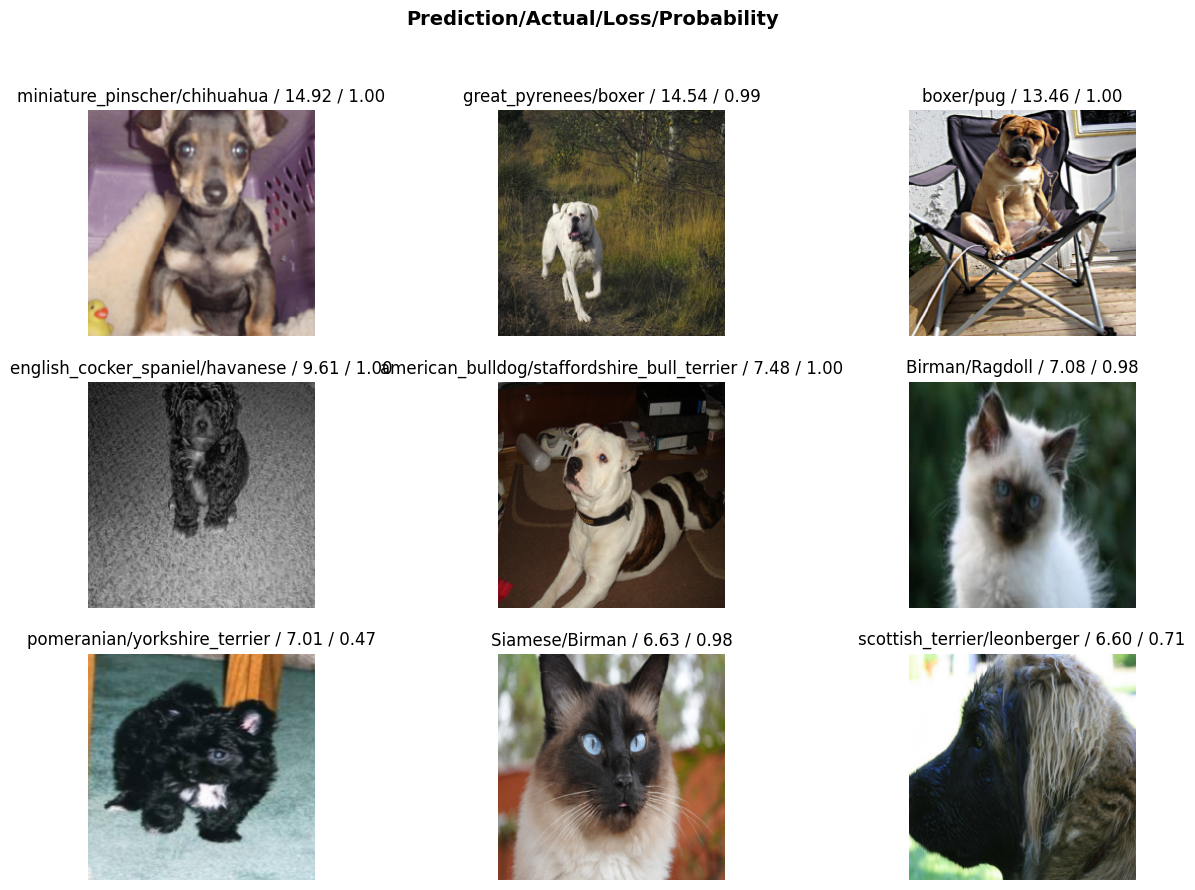

In [6]:
# Model Interpretation
from fastai.interpret import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

print(len(dls.valid_ds)==len(losses)==len(idxs)) # True

interp.plot_top_losses(k=9, figsize=(15,10)) # pred/actual/loss/prob

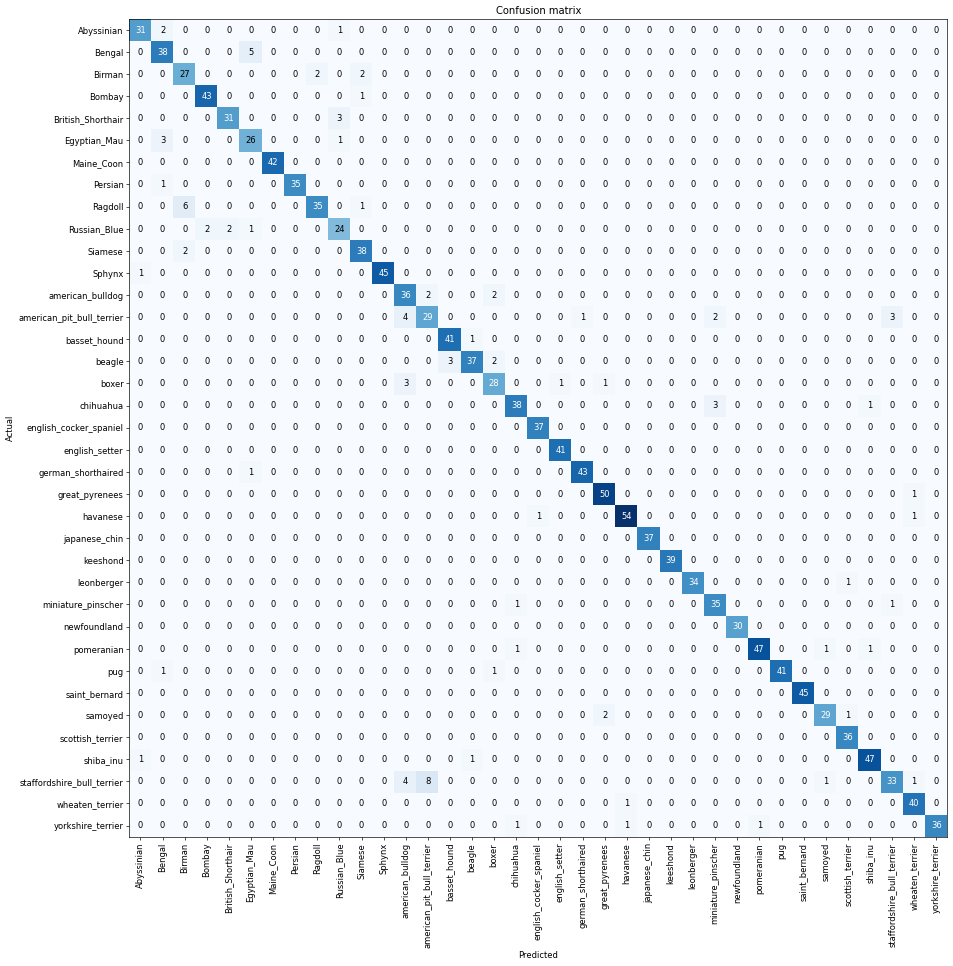

In [7]:
interp.plot_confusion_matrix(figsize=(16,16), dpi=60)

## Unfreeze Model, Fine Tune, Learning Rate

SuggestedLRs(valley=0.0006918309954926372)

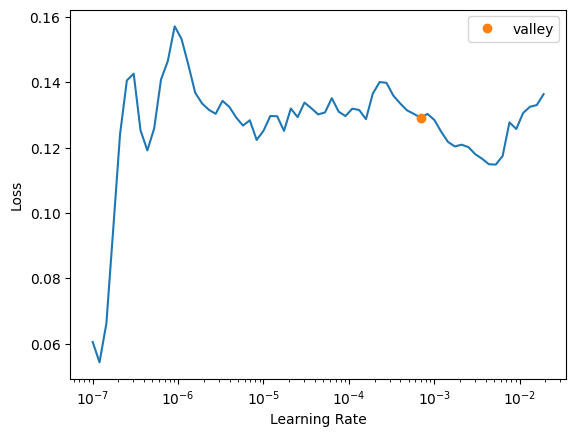

In [8]:
# Load a previously trained model ('model1_freezed')
learn.load('model1_freezed')

# Find the optimal learning rates for fine-tuning
learn.lr_find()

In [9]:
# Define a learning rate range (slice) for fine-tuning
lr = slice(1e-5, 1e-4)

# Unfreeze the model to allow all layers to be trained
learn.unfreeze()

# Fine-tune the model for 4 epochs with a learning rate within the defined range
learn.fit_one_cycle(4, lr_max=lr)

# Save the fine-tuned model with the name 'model2_unfreezed'
learn.save('model2_unfreezed')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.145025,0.233849,0.935724,0.064276,01:03
1,0.124441,0.216463,0.934371,0.065629,01:02
2,0.087406,0.213853,0.943166,0.056834,01:02
3,0.059933,0.209862,0.942490,0.057510,01:03


Path('models/model2_unfreezed.pth')

## Inference

In [10]:
!wget -O pug.jpg "https://th.bing.com/th/id/OIP.t7e7M-C6RM8T9a5xMgBsYgHaE8?w=273&h=182&c=7&r=0&o=5&dpr=2&pid=1.7"

--2023-09-11 19:08:39--  https://th.bing.com/th/id/OIP.t7e7M-C6RM8T9a5xMgBsYgHaE8?w=273&h=182&c=7&r=0&o=5&dpr=2&pid=1.7
Resolving th.bing.com (th.bing.com)... 96.17.103.26, 96.17.103.19, 96.17.103.33, ...
Connecting to th.bing.com (th.bing.com)|96.17.103.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17778 (17K) [image/jpeg]
Saving to: ‘pug.jpg’

pug.jpg             100%[===================>]  17.36K  --.-KB/s    in 0.003s  

2023-09-11 19:08:39 (6.23 MB/s) - ‘pug.jpg’ saved [17778/17778]



In [11]:
!tree /kaggle

/kaggle
├── input
├── lib
│   └── kaggle
│       └── gcp.py
├── src
│   └── script.ipynb
└── working
    ├── __notebook__.ipynb
    ├── models
    │   ├── model1_freezed.pth
    │   └── model2_unfreezed.pth
    └── pug.jpg

6 directories, 6 files


In [12]:
# Load the trained model
learn.load('model2_unfreezed')

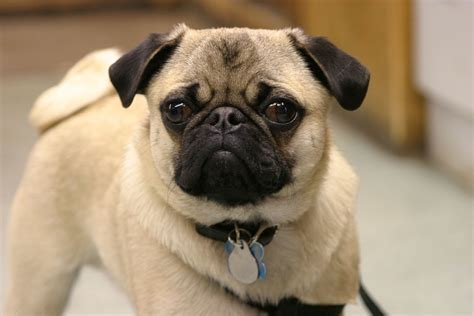

In [13]:
from PIL import Image
# Prepare the input image (you should replace 'image_path' with the path to your image)
input_image = Image.open('/kaggle/working/pug.jpg')
input_image

In [14]:
# Perform inference
prediction = learn.predict(input_image)

# Display the results
print("Predicted Class:", prediction[0])
print("Predicted Probabilities:", prediction[2])

Predicted Class: pug
Predicted Probabilities: tensor([1.5392e-09, 3.5758e-08, 7.0447e-09, 1.0427e-08, 5.9195e-07, 1.0777e-09,
        5.5459e-12, 4.3726e-08, 2.4441e-09, 7.4785e-11, 1.0886e-07, 2.6984e-10,
        1.1588e-07, 8.1282e-09, 4.4719e-09, 2.4156e-09, 2.0355e-08, 4.8717e-09,
        2.7462e-10, 7.0805e-11, 5.2403e-09, 1.2141e-09, 2.2327e-10, 6.0690e-10,
        4.9244e-10, 7.0878e-09, 3.9043e-08, 2.9694e-10, 4.5960e-09, 1.0000e+00,
        7.2234e-08, 5.7236e-10, 1.9060e-10, 4.0350e-09, 1.4490e-08, 2.7044e-08,
        4.9355e-08])


In [15]:
prediction

('pug',
 tensor(29),
 tensor([1.5392e-09, 3.5758e-08, 7.0447e-09, 1.0427e-08, 5.9195e-07, 1.0777e-09,
         5.5459e-12, 4.3726e-08, 2.4441e-09, 7.4785e-11, 1.0886e-07, 2.6984e-10,
         1.1588e-07, 8.1282e-09, 4.4719e-09, 2.4156e-09, 2.0355e-08, 4.8717e-09,
         2.7462e-10, 7.0805e-11, 5.2403e-09, 1.2141e-09, 2.2327e-10, 6.0690e-10,
         4.9244e-10, 7.0878e-09, 3.9043e-08, 2.9694e-10, 4.5960e-09, 1.0000e+00,
         7.2234e-08, 5.7236e-10, 1.9060e-10, 4.0350e-09, 1.4490e-08, 2.7044e-08,
         4.9355e-08]))

In [16]:
dls.vocab[29]

'pug'